# **Project Brief:**

---


This project uses the MAESTRO dataset to build a music-generating AI model.
The MAESTRO dataset contains paired audio and MIDI recordings of classical
piano performances, which serve as high-quality training data for sequence modeling.

The AI model is based on a Recurrent Neural Network (RNN), which is well-suited
for handling sequential data such as music. The RNN is trained to learn patterns
in musical composition and performance, and can generate new piano pieces that
mimic the style and structure of the dataset.

The goal of this project is to explore generative modeling in music using deep
learning techniques, and to demonstrate how AI can be applied to creative domains such as musical composition.

# Installing Packages

In [ ]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fluidsynth is already the newest version (2.2.5-1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
!pip install --upgrade pyfluidsynth

In [ ]:
!pip install pretty_midi

In [ ]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [ ]:
# To get the same results every time (Like Minecraft Seed)
seed = 34
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

# Downlaod the MAESTRO Dataset

In [ ]:
# Downloading the MAESTRO Dataset
data_dir = pathlib.Path('data/maestro-v2_extracted')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

In [ ]:
filenames = glob.glob(str(data_dir/'**/*.mid*'), recursive= True)
print('Number of files:', len(filenames))

Number of files: 1282


# Process MIDI file

In [ ]:
# Parsing 1 MDI File
sample_file = filenames[1]
print(sample_file)

data/maestro-v2_extracted/maestro-v2.0.0/2004/MIDI-Unprocessed_SMF_17_R1_2004_03-06_ORIG_MID--AUDIO_20_R2_2004_12_Track12_wav--1.midi


In [ ]:
# Generate a Runtime Object for MIDI File
pm = pretty_midi.PrettyMIDI(sample_file)

In [ ]:
# Play the MIDI File
def display_audio(pm: pretty_midi.PrettyMIDI, seconds = 30):
  waveform = pm.fluidsynth(fs = _SAMPLING_RATE)
  waveform_short = waveform[:_SAMPLING_RATE * seconds]
  return display.Audio(waveform_short, rate = _SAMPLING_RATE)

In [ ]:
display_audio(pm)

In [ ]:
# Print some information about the MIDI File
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


# Extract Notes

In [ ]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'f' duration={duration:.4f}')

0: pitch=88, note_name=E6, duration=0.0417
1: pitch=76, note_name=E5, duration=0.0354
2: pitch=75, note_name=D#5, duration=0.0312
3: pitch=74, note_name=D5, duration=0.0365
4: pitch=73, note_name=C#5, duration=0.0448
5: pitch=72, note_name=C5, duration=0.0354
6: pitch=76, note_name=E5, duration=0.0323
7: pitch=64, note_name=E4, duration=0.0302
8: pitch=76, note_name=E5, duration=0.0010
9: pitch=61, note_name=C#4, duration=0.0365


In [ ]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort notes by Start Time
  sorted_notes = sorted(instrument.notes, key = lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [ ]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,88,0.645833,0.687500,0.000000,0.041667
1,76,0.654167,0.689583,0.008333,0.035417
2,75,0.977083,1.008333,0.322917,0.031250
3,74,1.054167,1.090625,0.077083,0.036458
4,73,1.117708,1.162500,0.063542,0.044792


# Create a MIDI File

In [ ]:
def notes_to_midi(
    notes: pd.DataFrame,
    out_file: str,
    instrument_name: str,
    velocity: int = 100,
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(program = pretty_midi.instrument_name_to_program(instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(velocity = velocity, pitch = int(note['pitch']), start = start, end = end)
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [ ]:
example_file = 'example.mid'
example_pm = notes_to_midi(raw_notes, out_file=example_file, instrument_name=instrument_name)

In [ ]:
display_audio(example_pm)

# Create the Training Dataset

In [ ]:
num_files = 10
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [ ]:
n_notes = len(all_notes)
print("Number of Notes Parsed: ", n_notes)

Number of Notes Parsed:  63788


In [ ]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [ ]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [ ]:
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1


  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)


  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)


  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x


  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [ ]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.5625     0.         0.034375  ]
 [0.5234375  0.49166667 0.03125   ]
 [0.5        0.49583333 0.03645833]
 [0.375      0.21875    0.05      ]
 [0.28125    0.22604167 0.04166667]
 [0.5390625  0.23020833 0.04479167]
 [0.484375   0.253125   0.034375  ]
 [0.375      0.2125     0.046875  ]
 [0.28125    0.22708333 0.04166667]
 [0.5234375  0.22604167 0.03645833]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=57.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.20937500000000053>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.19583333333333286>}


In [ ]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

# Create and Train Model

In [ ]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [ ]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 25, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 128)       │     67,584 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration (Dense)    │ (None, 1)         │        129 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pitch (Dense)       │ (None, 128)       │     16,512 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ step (Dense)        │ (None, 1)         │        129 │ lstm_3[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,354 (329.51 KB)

 Trainable params: 84,354 (329.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
losses = model.evaluate(train_ds, return_dict=True)
losses

996/996 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - duration_loss: 0.2019 - loss: 5.3001 - pitch_loss: 4.8488 - step_loss: 0.2494


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


{'duration_loss': 0.2026246190071106,
 'loss': 5.304973602294922,
 'pitch_loss': 4.849073886871338,
 'step_loss': 0.2532714307308197}

In [ ]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [ ]:
model.evaluate(train_ds, return_dict=True)

996/996 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - duration_loss: 0.2019 - loss: 0.6937 - pitch_loss: 4.8488 - step_loss: 0.2494


{'duration_loss': 0.2024213820695877,
 'loss': 0.6976495981216431,
 'pitch_loss': 4.844210147857666,
 'step_loss': 0.253017395734787}

In [ ]:
# Callback setup
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/best_ckpt.weights.h5', # Added .weights.h5 to the filepath
        save_weights_only=True,
        save_best_only=True,
        monitor='val_loss',
        verbose=1),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [ ]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
996/996 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - duration_loss: 0.1208 - loss: 0.3776 - pitch_loss: 4.0799 - step_loss: 0.0528
Epoch 2/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: duration_loss,loss,pitch_loss,step_loss
  current = self.get_monitor_value(logs)


996/996 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - duration_loss: 0.1123 - loss: 0.3509 - pitch_loss: 3.8632 - step_loss: 0.0455
Epoch 3/50
996/996 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - duration_loss: 0.1090 - loss: 0.3424 - pitch_loss: 3.7997 - step_loss: 0.0434
Epoch 4/50
996/996 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - duration_loss: 0.1064 - loss: 0.3375 - pitch_loss: 3.7830 - step_loss: 0.0420
Epoch 5/50
996/996 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - duration_loss: 0.1043 - loss: 0.3342 - pitch_loss: 3.7756 - step_loss: 0.0411
Epoch 6/50
996/996 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - duration_loss: 0.1029 - loss: 0.3310 - pitch_loss: 3.7671 - step_loss: 0.0397
Epoch 7/50
996/996 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - duration_loss: 0.1008 - loss: 0.3272 - pitch_loss: 3.7613 - step_loss: 0.0383
Epoch 8/50
996/996 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - duration_loss: 0.0987 - loss: 0.3239 - pitch_loss: 3.7549 - step_loss: 0.0374
Epoch 9/50
996/996 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - duration_loss: 0.0966 - loss: 0

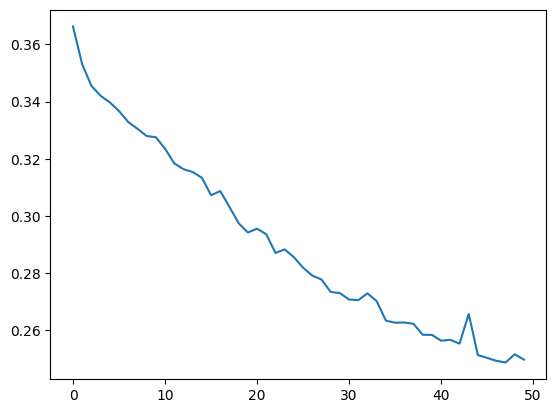

In [ ]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

# Generate Notes

In [ ]:
def predict_next_note(
    notes: np.ndarray,
    model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [ ]:
temperature = 4.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━

In [ ]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,93,0.088546,0.078803,0.088546,0.167349
1,74,0.145177,0.000000,0.233723,0.233723
2,74,0.144876,0.000000,0.378599,0.378599
3,84,0.145341,0.000000,0.523940,0.523940
4,79,0.144991,0.000000,0.668931,0.668931
5,85,0.144133,0.000000,0.813064,0.813064
6,90,0.143916,0.000000,0.956980,0.956980
7,86,0.141762,0.000000,1.098742,1.098742
8,79,0.135723,0.000000,1.234466,1.234466
9,78,0.145570,0.000000,1.380036,1.380036


In [ ]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

NameError: name 'notes_to_midi' is not defined